# Perturbation Prediction with TRVAE

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown
from scipy.sparse import issparse
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
from scipy import stats
# from scarches.models.trvae._utils import reg_mean_plot, reg_var_plot

 captum (see https://github.com/pytorch/captum).


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training options

In [4]:
condition_key = 'condition'
cell_type_key = 'cell_label'

trvae_epochs = 2000

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 75,
    "reduce_lr": False
}

### Download Dataset and Preprocess

In [5]:
url = "https://drive.google.com/uc?id=1v3-ZmktCS61-oe2v1VtHtIhCeQl78SCN"
output = 'haber_count.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1v3-ZmktCS61-oe2v1VtHtIhCeQl78SCN
To: /Users/chelseaalexandra.bright/theislab/scarches/notebooks/haber_count.h5ad
100%|██████████| 34.6M/34.6M [00:03<00:00, 10.1MB/s]


'haber_count.h5ad'

In [6]:
adata = sc.read("haber_count.h5ad")

In [7]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1000,
    batch_key="condition",
    subset=True)

In [8]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


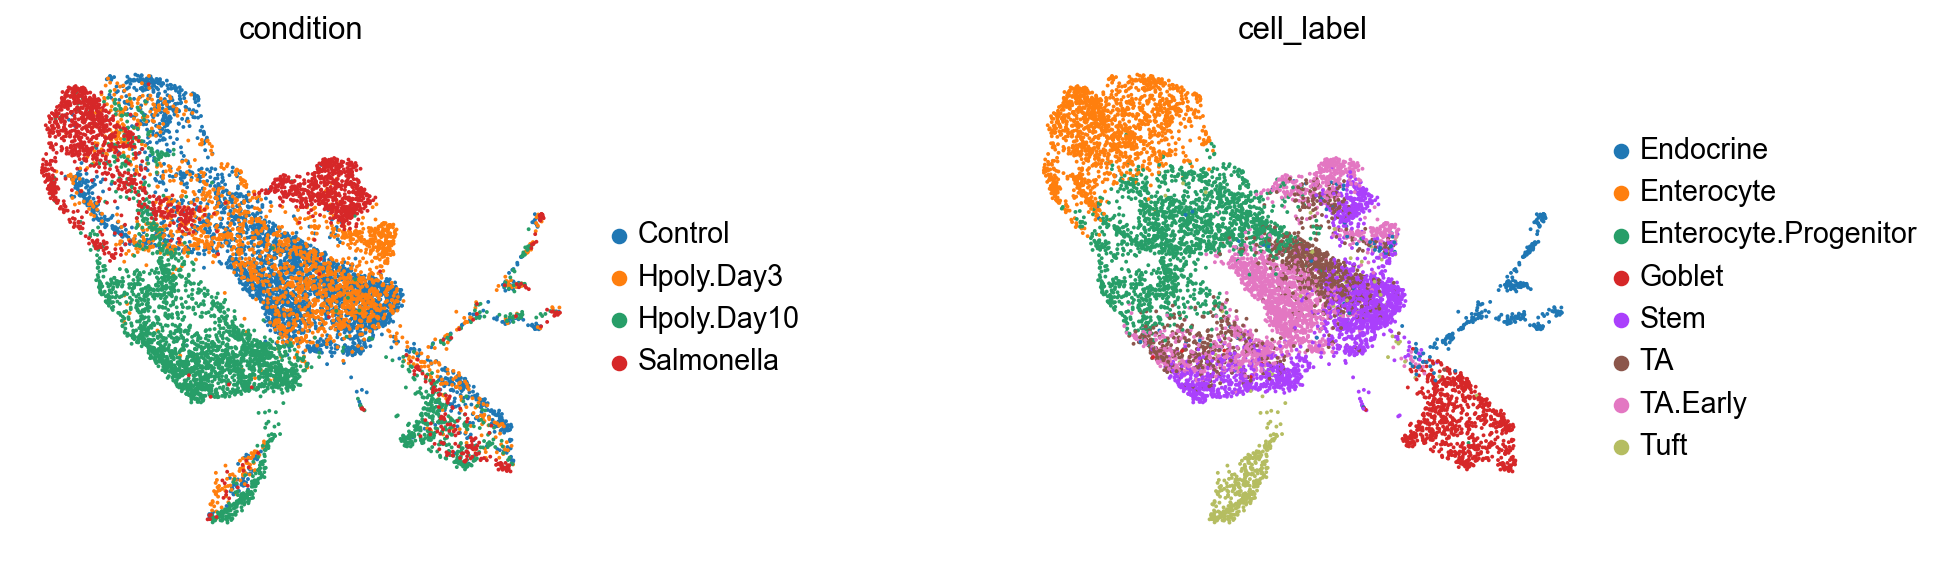

In [9]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], 
           wspace=0.6, 
           frameon=False)

In [10]:
adata.obs.groupby([cell_type_key, condition_key]).size()

cell_label             condition  
Endocrine              Control        112
                       Hpoly.Day3     117
                       Hpoly.Day10     82
                       Salmonella      69
Enterocyte             Control        424
                       Hpoly.Day3     201
                       Hpoly.Day10    128
                       Salmonella     705
Enterocyte.Progenitor  Control        545
                       Hpoly.Day3     462
                       Hpoly.Day10    586
                       Salmonella     229
Goblet                 Control        216
                       Hpoly.Day3      99
                       Hpoly.Day10    317
                       Salmonella     126
Stem                   Control        670
                       Hpoly.Day3     388
                       Hpoly.Day10    592
                       Salmonella     207
TA                     Control        421
                       Hpoly.Day3     302
                       Hpoly.Day10    353

In [11]:
conditions = ['Control', 'Hpoly.Day3', 'Hpoly.Day10', 'Salmonella']
target_conditions = ["Hpoly.Day3", "Hpoly.Day10", "Salmonella"]
specific_celltype = "Tuft"

In [12]:
train_adata = adata[~((adata.obs[cell_type_key] == specific_celltype) & (adata.obs[condition_key].isin(target_conditions)))]

### Create TRVAE model and train it on dataset

Create the trVAE model instance with "recon_loss='mse'". Insert "recon_loss='nb'", or "recon_loss='zinb'", to change the reconstruction loss.

In [13]:
trvae = sca.models.TRVAE(
    adata=train_adata,
    condition_key=condition_key,
    conditions=conditions,
    hidden_layer_sizes=[128, 128],
    recon_loss="mse",
    dr_rate=0.2,
    use_bn=True
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 4
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 4
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [14]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    batch_size=512,
    clip_value=100,   
)

Preparing (9493, 1000)
Instantiating dataset
 |████----------------| 23.5%  - val_loss: 63.0497093201 - val_recon_loss: 55.2986240387 - val_kl_loss: 5.6500446796 - val_mmd_loss: 2.101039886561
Stopping early: no improvement of more than 0 nats in 75 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 393


### Create anndata file of latent representation and compute UMAP

In [15]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_label'] = train_adata.obs[cell_type_key].tolist()
adata_latent.obs['condition'] = train_adata.obs[condition_key].tolist()

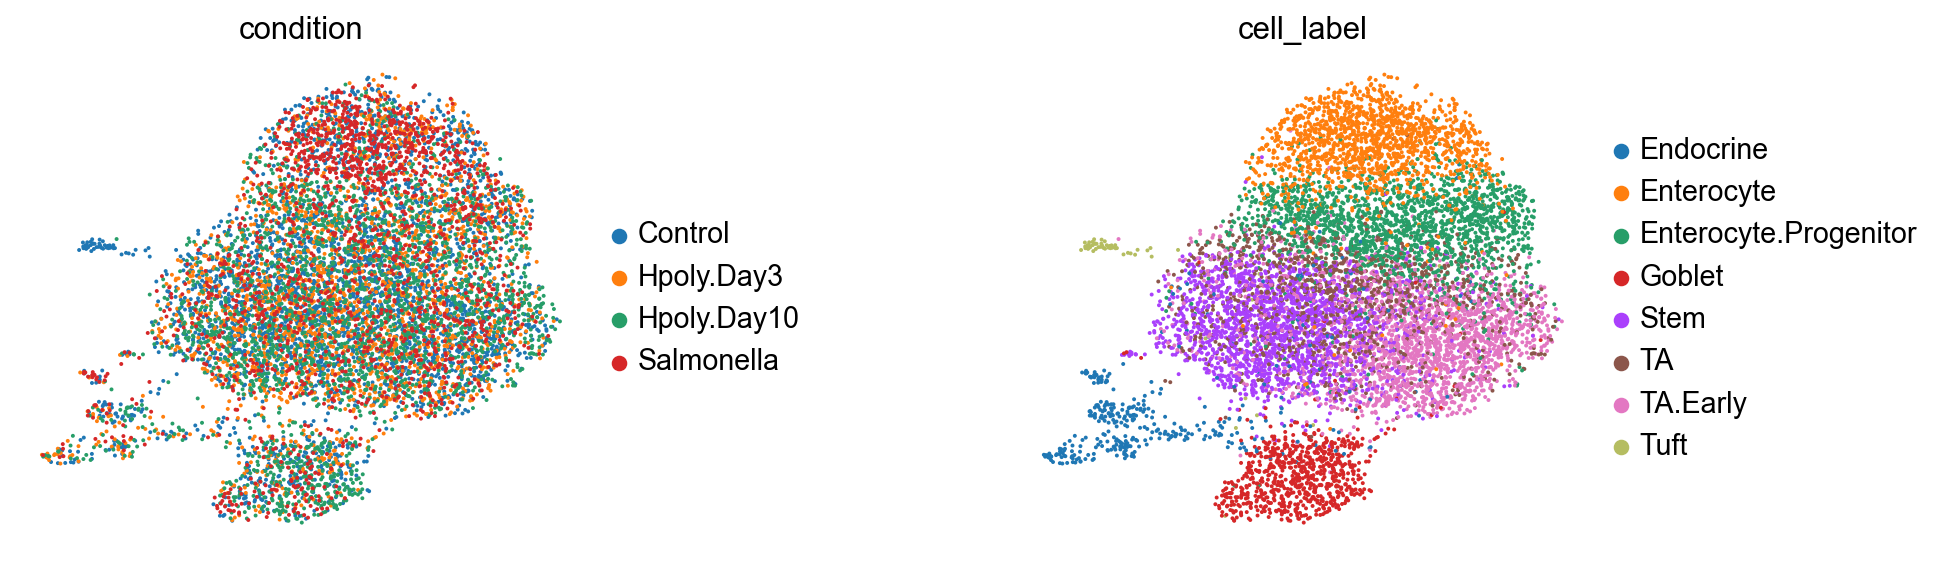

In [16]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['condition', 'cell_label'],
           frameon=False,
           wspace=0.6,
           )

### Get corrected gene expression data

Predict "Hpoly.Day10" Tuft cell states from "Control" Tuft cell states

In [17]:
cell_type_adata = train_adata[train_adata.obs[cell_type_key] == specific_celltype]

In [18]:
def get_reconstruction(model, x, encoder_labels=None, decoder_labels = None):

    x_ = torch.log(1 + x)
    if model.model.recon_loss == 'mse':
        x_ = x
    
    z_mean, z_log_var = model.model.encoder(x_, encoder_labels)
    latent = model.model.sampling(z_mean, z_log_var)
    output = model.model.decoder(latent, decoder_labels)
    return output[0]

In [19]:
def perturbation_prediction(model, adata, source_cond, target_cond):

        device = next(model.model.parameters()).device

        source_adata = adata[adata.obs[condition_key] == source_cond]

        from scarches.dataset.trvae._utils import label_encoder
        encoder_labels = label_encoder(source_adata, model.model.condition_encoder, condition_key)
        decoder_labels = np.zeros_like(encoder_labels) + model.model.condition_encoder[target_cond]

        x = adata.X

        latents = []
        indices = torch.arange(x.shape[0])
        subsampled_indices = indices.split(512)
        for batch in subsampled_indices:
                x_batch = x[batch, :]
                if issparse(x_batch):
                        x_batch = x_batch.toarray()
                x_batch = torch.tensor(x_batch, device=device)
                encoder_labels = torch.tensor(encoder_labels, device=device)
                decoder_labels = torch.tensor(decoder_labels, device=device)
                latent = get_reconstruction(model, x_batch, encoder_labels[batch], decoder_labels[batch])
                latents += [latent.cpu().detach()]

        return np.array(torch.cat(latents))

In [20]:
corrected_data = perturbation_prediction(trvae, cell_type_adata, "Control", "Hpoly.Day10")

In [21]:
corrected_adata = cell_type_adata[cell_type_adata.obs[condition_key] == "Control"].copy()
corrected_adata.X = corrected_data
corrected_adata.obs['condition'] = 'pred'

### Evaluation of the prediction

In [22]:
target_cell_adata = adata[adata.obs[cell_type_key] ==specific_celltype]

In [23]:
sc.tl.rank_genes_groups(target_cell_adata, groupby="condition", method="wilcoxon")
diff_genes = target_cell_adata.uns["rank_genes_groups"]["names"]["Hpoly.Day10"]
print(diff_genes)

['Defa24' 'Gm15284' 'Defa22' 'Defa17' 'Spink4' 'AY761184' 'Lyz1' 'Defa21'
 'Itln1' 'Gm14851' 'Ptpn18' 'Cd24a' 'AA467197' 'Snrnp25' 'Mgst3'
 'Tmem176a' 'Ang4' 'Hpgds' 'Ethe1' 'Ly6g6d' 'Alox5ap' 'Cdkn1a' 'Hck'
 'Skap2' 'Lrmp' 'Phlda1' 'Sh2d6' 'Acot7' 'Crip1' 'Car2' 'Kit' 'Ltc4s'
 'Spib' 'Irf7' 'Marcksl1' 'Tmem176b' 'Rac2' 'Tspan6' 'Hmx2' 'Reg3g' 'Bpgm'
 'X1810046K07Rik' 'Gng13' 'Reep5' 'Tppp3' 'Tspan13' 'Inpp5d' 'Cbr3' 'Fyb'
 'Tuba1a' 'St6galnac6' 'Rgs2' 'Kctd12' 'Mptx2' 'Espn' 'Ffar3' 'Ccdc28b'
 'Avil' 'S100a1' 'Reg3b' 'Pik3r5' 'Clps' 'Vav1' 'S100a13' 'Sox9' 'Bmx'
 'Krt18' 'Oas2' 'Smim6' 'Ptpn6' 'Cwh43' 'Krt8' 'Fam221a' 'Tmem38b' 'Usp18'
 'Tmem245' 'Ly6g6f' 'Basp1' 'Pea15a' 'Aldh2' 'Matk' 'Limd2' 'Defa.rs1'
 'Fxyd3' 'Osbpl3' 'Selm' 'Plcg2' 'Ctsc' 'Tmem229a' 'Ckmt1' 'C2cd4b'
 'Cenpa' 'Rhoc' 'Fam105a' 'Ncf2' 'Alox5' 'Dclk1' 'Ifi27l2a' 'Mphosph8'
 'X4930539E08Rik' 'Defa3' 'Atp2a3' 'H2afx' 'Morn2' 'Ccnt2' 'Isg15'
 'Siglecf' 'Ccdc109b' 'Folr1' 'Pygl' 'Zfp428' 'Ppp1r14c' 'Fam129b'
 'Onecut2' 

In [24]:
dis_adata = adata[(adata.obs[cell_type_key] == specific_celltype) & (adata.obs[condition_key] == 'Hpoly.Day10')]
eval_adata = dis_adata.concatenate(corrected_adata)

Compare trVAE-predicted and real infected Tuft cells mean expression with the top 10 differentially expressed genes highlighted in red

In [ ]:
def reg_mean_plot(
    adata,
    condition_key,
    target_condition,
    labels,
    path_to_save="./reg_mean.pdf",
    save=False,
    gene_list=None,
    show=False,
    top_100_genes=None,
    verbose=False,
    legend=True,
    title=None,
    x_coeff=0.30,
    y_coeff=0.8,
    fontsize=14,
    **kwargs,
):
    """
    Plots mean matching figure for a set of specific genes.

    Parameters
    ----------
    adata: `~anndata.AnnData`
        AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
        AnnData object used to initialize the model. Must have been setup with `batch_key` and `labels_key`,
        corresponding to batch and cell type metadata, respectively.
    axis_keys: dict
        Dictionary of `adata.obs` keys that are used by the axes of the plot. Has to be in the following form:
            `{"x": "Key for x-axis", "y": "Key for y-axis"}`.
    labels: dict
        Dictionary of axes labels of the form `{"x": "x-axis-name", "y": "y-axis name"}`.
    path_to_save: basestring
        path to save the plot.
    save: boolean
        Specify if the plot should be saved or not.
    gene_list: list
        list of gene names to be plotted.
    show: bool
        if `True`: will show to the plot after saving it.

    """

    sns.set_theme()
    sns.set_theme(color_codes=True)

    axis_keys = {"x":"other", "y":target_condition}

    diff_genes = top_100_genes
    target_cd = adata[adata.obs[condition_key] == target_condition]
    other_cd = adata[adata.obs[condition_key] != target_condition]
    if diff_genes is not None:
        if hasattr(diff_genes, "tolist"):
            diff_genes = diff_genes.tolist()
        adata_diff = adata[:, diff_genes]
        target_diff = adata_diff[adata_diff.obs[condition_key] == target_condition]
        other_diff = adata_diff[adata_diff.obs[condition_key] != target_condition]
        x_diff = np.asarray(np.mean(target_diff.X, axis=0)).ravel()
        y_diff = np.asarray(np.mean(other_diff.X, axis=0)).ravel()
        m, b, r_value_diff, p_value_diff, std_err_diff = stats.linregress(
            x_diff, y_diff
        )
        if verbose:
            print("top_100 DEGs mean: ", r_value_diff**2)
    x = np.asarray(np.mean(other_cd.X, axis=0)).ravel()
    y = np.asarray(np.mean(target_cd.X, axis=0)).ravel()
    m, b, r_value, p_value, std_err = stats.linregress(x, y)
    if verbose: 
        print("All genes mean: ", r_value**2)
    df = pd.DataFrame({axis_keys["x"]: x, axis_keys["y"]: y})
    ax = sns.regplot(x=axis_keys["x"], y=axis_keys["y"], data=df)
    ax.tick_params(labelsize=fontsize)
    if "range" in kwargs:
        start, stop, step = kwargs.get("range")
        ax.set_xticks(np.arange(start, stop, step))
        ax.set_yticks(np.arange(start, stop, step))
    ax.set_xlabel(labels["x"], fontsize=fontsize)
    ax.set_ylabel(labels["y"], fontsize=fontsize)
    if gene_list is not None:
        texts = []
        for i in gene_list:
            j = adata.var_names.tolist().index(i)
            x_bar = x[j]
            y_bar = y[j]
            texts.append(pyplot.text(x_bar, y_bar, i, fontsize=11, color="black"))
            pyplot.plot(x_bar, y_bar, "o", color="red", markersize=5)

    if legend:
        pyplot.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    if title is None:
        pyplot.title("", fontsize=fontsize)
    else:
        pyplot.title(title, fontsize=fontsize)
    ax.text(
        max(x) - max(x) * x_coeff,
        max(y) - y_coeff * max(y),
        r"$\mathrm{R^2_{\mathrm{\mathsf{all\ genes}}}}$= " + f"{r_value ** 2:.2f}",
        fontsize=kwargs.get("textsize", fontsize),
    )
    if diff_genes is not None:
        ax.text(
            max(x) - max(x) * x_coeff,
            max(y) - (y_coeff + 0.15) * max(y),
            r"$\mathrm{R^2_{\mathrm{\mathsf{top\ 100\ DEGs}}}}$= "
            + f"{r_value_diff ** 2:.2f}",
            fontsize=kwargs.get("textsize", fontsize),
        )
    if save:
        pyplot.savefig(f"{path_to_save}", bbox_inches="tight", dpi=100)
    if show:
        pyplot.show()
    pyplot.close()
    if diff_genes is not None:
        return r_value**2, r_value_diff**2
    else:
        return r_value**2

In [25]:
def reg_var_plot(
    adata,
    condition_key,
    target_condition,
    labels,
    path_to_save="./reg_var.pdf",
    save=False,
    gene_list=None,
    show=False,
    top_100_genes=None,
    verbose=False,
    legend=True,
    title=None,
    x_coeff=0.30,
    y_coeff=0.8,
    fontsize=14,
    **kwargs,
):
    """
    Plots variance matching figure for a set of specific genes.

    Parameters
    ----------
    adata: `~anndata.AnnData`
        AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
        AnnData object used to initialize the model. Must have been setup with `batch_key` and `labels_key`,
        corresponding to batch and cell type metadata, respectively.
    axis_keys: dict
        Dictionary of `adata.obs` keys that are used by the axes of the plot. Has to be in the following form:
            `{"x": "Key for x-axis", "y": "Key for y-axis"}`.
    labels: dict
        Dictionary of axes labels of the form `{"x": "x-axis-name", "y": "y-axis name"}`.
    path_to_save: basestring
        path to save the plot.
    save: boolean
        Specify if the plot should be saved or not.
    gene_list: list
        list of gene names to be plotted.
    show: bool
        if `True`: will show to the plot after saving it.

    """

    sns.set_theme()
    sns.set_theme(color_codes=True)

    axis_keys = {"x":"other", "y":target_condition}

    diff_genes = top_100_genes
    target_cd = adata[adata.obs[condition_key] == target_condition]
    other_cd = adata[adata.obs[condition_key] != target_condition]
    if diff_genes is not None:
        if hasattr(diff_genes, "tolist"):
            diff_genes = diff_genes.tolist()
        adata_diff = adata[:, diff_genes]
        target_diff = adata_diff[adata_diff.obs[condition_key] == target_condition]
        other_diff = adata_diff[adata_diff.obs[condition_key] != target_condition]
        x_diff = np.asarray(np.var(target_diff.X, axis=0)).ravel()
        y_diff = np.asarray(np.var(other_diff.X, axis=0)).ravel()
        m, b, r_value_diff, p_value_diff, std_err_diff = stats.linregress(
            x_diff, y_diff
        )
        if verbose:
            print("top_100 DEGs var: ", r_value_diff**2)
    x = np.asarray(np.var(other_cd.X, axis=0)).ravel()
    y = np.asarray(np.var(target_cd.X, axis=0)).ravel()
    m, b, r_value, p_value, std_err = stats.linregress(x, y)
    if verbose: 
        print("All genes var: ", r_value**2)
    df = pd.DataFrame({axis_keys["x"]: x, axis_keys["y"]: y})
    ax = sns.regplot(x=axis_keys["x"], y=axis_keys["y"], data=df)
    ax.tick_params(labelsize=fontsize)
    if "range" in kwargs:
        start, stop, step = kwargs.get("range")
        ax.set_xticks(np.arange(start, stop, step))
        ax.set_yticks(np.arange(start, stop, step))
    ax.set_xlabel(labels["x"], fontsize=fontsize)
    ax.set_ylabel(labels["y"], fontsize=fontsize)
    if gene_list is not None:
        texts = []
        for i in gene_list:
            j = adata.var_names.tolist().index(i)
            x_bar = x[j]
            y_bar = y[j]
            texts.append(pyplot.text(x_bar, y_bar, i, fontsize=11, color="black"))
            pyplot.plot(x_bar, y_bar, "o", color="red", markersize=5)

    if legend:
        pyplot.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    if title is None:
        pyplot.title("", fontsize=fontsize)
    else:
        pyplot.title(title, fontsize=fontsize)
    ax.text(
        max(x) - max(x) * x_coeff,
        max(y) - y_coeff * max(y),
        r"$\mathrm{R^2_{\mathrm{\mathsf{all\ genes}}}}$= " + f"{r_value ** 2:.2f}",
        fontsize=kwargs.get("textsize", fontsize),
    )
    if diff_genes is not None:
        ax.text(
            max(x) - max(x) * x_coeff,
            max(y) - (y_coeff + 0.15) * max(y),
            r"$\mathrm{R^2_{\mathrm{\mathsf{top\ 100\ DEGs}}}}$= "
            + f"{r_value_diff ** 2:.2f}",
            fontsize=kwargs.get("textsize", fontsize),
        )
    if save:
        pyplot.savefig(f"{path_to_save}", bbox_inches="tight", dpi=100)
    if show:
        pyplot.show()
    pyplot.close()
    if diff_genes is not None:
        return r_value**2, r_value_diff**2
    else:
        return r_value**2


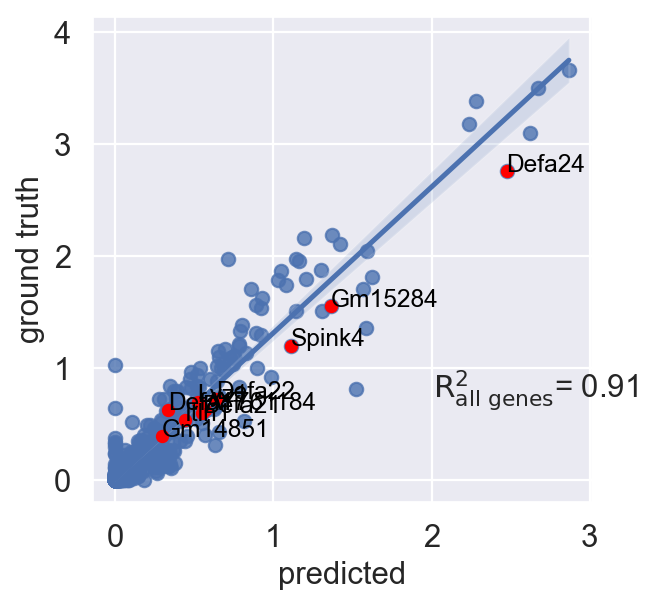

In [27]:
r2_value = reg_mean_plot(
    eval_adata,
    condition_key="condition",
    target_condition="Hpoly.Day10",
    gene_list=diff_genes[:10],
    labels={"x": "predicted", "y": "ground truth"},
    show=True,
    legend=False
)

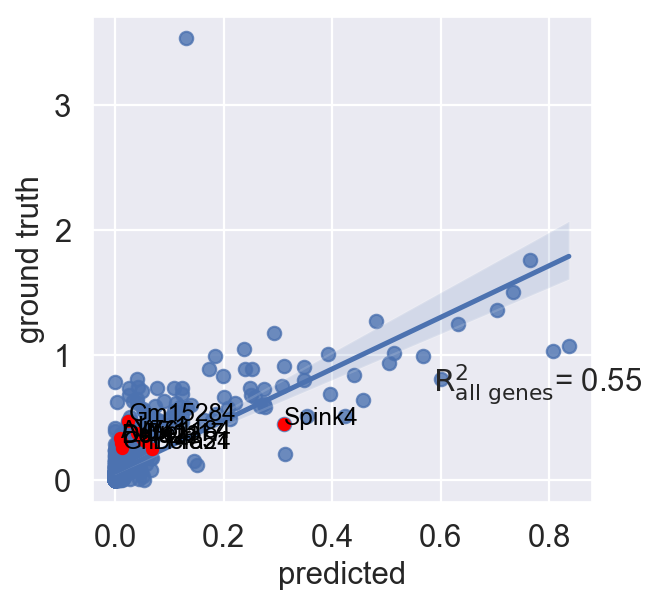

In [28]:
r2_value_var = reg_var_plot(
    eval_adata,
    condition_key="condition",
    target_condition="Hpoly.Day10",
    gene_list=diff_genes[:10],
    labels={"x": "predicted", "y": "ground truth"},
    show=True,
    legend=False
)